In [1]:
import os
import signal
import sys
import time

import example_robot_data
import numpy as np
import pinocchio as pin
import pinocchio.visualize

import crocoddyl

In [2]:
WITHDISPLAY = "display"

# Loading the anymal model
a1 = example_robot_data.load("a1")
rmodel = a1.model

lims = rmodel.effortLimit
lims *= 0.5  # reduced artificially the torque limits
rmodel.effortLimit = lims

lfFoot, rfFoot, lhFoot, rhFoot = "FL_foot", "FR_foot", "RL_foot", "RR_foot"
lfCalf, rfCalf, lhCalf, rhCalf = "FL_calf", "FR_calf", "RL_calf", "RR_calf"
body = "trunk"

rdata = rmodel.createData()
state = crocoddyl.StateMultibody(rmodel)
actuation = crocoddyl.ActuationModelFloatingBase(state)
lf_id = rmodel.getFrameId(lfFoot)
rf_id = rmodel.getFrameId(rfFoot)
lh_id = rmodel.getFrameId(lhFoot)
rh_id = rmodel.getFrameId(rhFoot)
body_id = rmodel.getFrameId(body)
lfcalf_id = rmodel.getFrameId(lfCalf)
rfcalf_id = rmodel.getFrameId(rfCalf)
lhcalf_id = rmodel.getFrameId(lhCalf)
rhcalf_id = rmodel.getFrameId(rhCalf)

_integrator = 'euler'
_control = 'one'

q0 = rmodel.referenceConfigurations["standing"]
rmodel.defaultState = np.concatenate([q0, np.zeros(rmodel.nv)])
x0 = rmodel.defaultState

In [3]:
contacts = crocoddyl.ContactModelMultiple(state, actuation.nu)
xref = np.array([0, 0.0, 0])
gains = np.array([0,0])
lf_contact = crocoddyl.ContactModel3D(
    state, 
    lf_id, 
    xref,
    pin.LOCAL_WORLD_ALIGNED,
    actuation.nu,
    gains
)
rf_contact = crocoddyl.ContactModel3D(
    state, 
    rf_id, 
    xref,
    pin.LOCAL_WORLD_ALIGNED,
    actuation.nu,
    gains
)
lh_contact = crocoddyl.ContactModel3D(
    state, 
    lh_id, 
    xref,
    pin.LOCAL_WORLD_ALIGNED,
    actuation.nu,
    gains
)
rh_contact = crocoddyl.ContactModel3D(
    state, 
    rh_id, 
    xref,
    pin.LOCAL_WORLD_ALIGNED,
    actuation.nu,
    gains
)
contacts.addContact("lf_contact", lf_contact)
contacts.addContact("rf_contact", rf_contact)
contacts.addContact("lh_contact", lh_contact)
contacts.addContact("rh_contact", rh_contact)

In [4]:
from utils.transforms import rpy_to_quaternion, csquat_to_rpy, csrpy_to_quat, quat_to_rpy
from utils.costs import handstand, crouch, add_lf_cost
from utils.cimpc import cimpc, cimpc_adaptive
from utils.models import ContactModel, IAM_shoot

In [5]:
display = crocoddyl.MeshcatDisplay(a1)
display.rate = -1
display.freq = 1
display.robot.viewer.jupyter_cell()


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


/usr/bin/xdg-open: 882: x-www-browser: not found
/usr/bin/xdg-open: 882: firefox: not found
/usr/bin/xdg-open: 882: iceweasel: not found
/usr/bin/xdg-open: 882: seamonkey: not found


/usr/bin/xdg-open: 882: mozilla: not found


/usr/bin/xdg-open: 882: epiphany: not found
/usr/bin/xdg-open: 882: konqueror: not found
/usr/bin/xdg-open: 882: chromium: not found
/usr/bin/xdg-open: 882: chromium-browser: not found
/usr/bin/xdg-open: 882: google-chrome: not found
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening 'http://127.0.0.1:7000/static/'


In [6]:
%load_ext line_profiler
from utils.models import DAM_contact
def test_fun():
    costs_r,costs_t = handstand(rmodel, state, actuation)

    DT, N = 2.5e-2, 20
    rho = 0 # 脚离地
    contact_ids = [lf_id, rf_id, lh_id, rh_id]
    # [lfcalf_id, rfcalf_id, lhcalf_id, rhcalf_id]
    contact_model = ContactModel(state,contact_ids)
    # 减少滑动
    add_lf_cost(costs_r,state,actuation,contact_ids)
    actionmodels = IAM_shoot(N,state, actuation, (costs_r,costs_t), contact_model, DT, rho)

    # actionmodels = IAM_ccdContactFwd(N, state, actuation, (costs_r,costs_t), contacts, DT)
    # actionmodels = IAM_ccdFreeFwd(N, state, actuation, (costs_r,costs_t), DT)

    maxiter = 1
    is_feasible = False
    init_reg = 0.1

    problem = crocoddyl.ShootingProblem(x0, actionmodels[:-1], actionmodels[-1])
    solver = crocoddyl.SolverFDDP(problem)
    # 调cost权重，提前测试空中不会乱动
    x00 = x0.copy()
    x00[2] += 0.1
    xs = [x00] * (solver.problem.T + 1) # list of array即可
    us = [np.zeros(12)] * solver.problem.T

    # x0 = rmodel.defaultState
    # xs = [x0] * (solver.problem.T + 1)
    
    # ustatic = solver.problem.quasiStatic([x0] * solver.problem.T) # 初始化很重要,但要很长时间算
    # us = [ustatic[0]]*solver.problem.T

    print('Initialization success !')
    solver.solve(xs, us, maxiter, is_feasible, init_reg)

    return 0
test_fun()
%lprun -T line_profiler_output.txt -f DAM_contact.collision_test -f DAM_contact.calc -f DAM_contact.calcDiff test_fun()

Initialization success !
Initialization success !

*** Profile printout saved to text file 'line_profiler_output.txt'. 


Timer unit: 1e-09 s

Total time: 0.0674773 s
File: /home/douyuanke/cimpc1/ftddp/utils/models.py
Function: collision_test at line 120

Line #      Hits         Time  Per Hit   % Time  Line Contents
   120                                               @profile
   121                                               def collision_test(self,data,tau,v):
   122                                                   
   123       370     170567.0    461.0      0.3          for i, contact_id in enumerate(self.contact_ids):
   124       296     422385.0   1427.0      0.6              oMf = data.pinocchio.oMf[contact_id]
   125       296     178428.0    602.8      0.3              pos = oMf.translation
   126       296     207978.0    702.6      0.3              rot = oMf.rotation
   127       296     720951.0   2435.6      1.1              self.contact_objects[i].setTransform(coal.Transform3s(rot, pos))
   128                                                       
   129       296    4673482.0  15788.

Initialization success !
iter    cost       merit      stop      |grad|      preg       dreg      step   ||ffeas||  ||gfeas||  ||hfeas||   dV-exp       dV      dPhi-exp     dPhi
   0  2.243e+04  0.000e+00  5.742e+03  3.283e+04  1.000e-01  1.000e-01  0.2500  2.064e+00  0.000e+00  0.000e+00  6.334e+03  1.438e+03  0.000e+00  0.000e+00
   1  1.809e+04  0.000e+00  9.427e+03  3.037e+04  1.000e-01  1.000e-01  0.2500  1.548e+00  0.000e+00  0.000e+00  6.219e+03  4.340e+03  0.000e+00  0.000e+00
   2  1.242e+04  0.000e+00  1.328e+04  3.208e+04  1.000e-01  1.000e-01  0.2500  1.161e+00  0.000e+00  0.000e+00  6.666e+03  5.677e+03  0.000e+00  0.000e+00
   3  9.832e+03  0.000e+00  1.004e+04  2.299e+04  1.000e-01  1.000e-01  0.1250  8.708e-01  0.000e+00  0.000e+00  2.640e+03  2.585e+03  0.000e+00  0.000e+00
   4  9.324e+03  0.000e+00  8.170e+03  1.872e+04  1.000e-01  1.000e-01  0.0312  7.619e-01  0.000e+00  0.000e+00  5.725e+02  5.076e+02  0.000e+00  0.000e+00
   5  9.202e+03  0.000e+00  7.747e+03  1.7

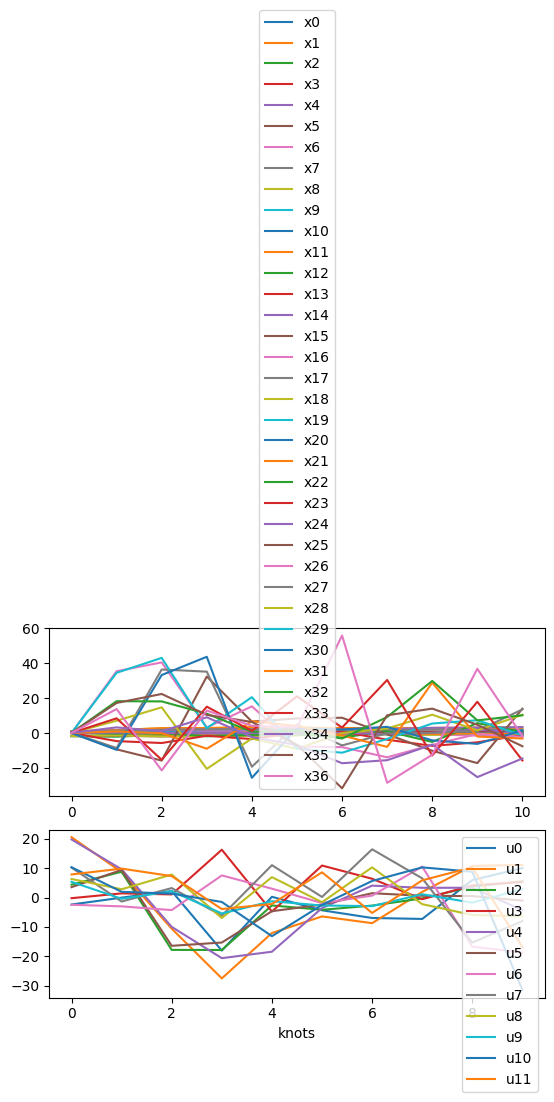

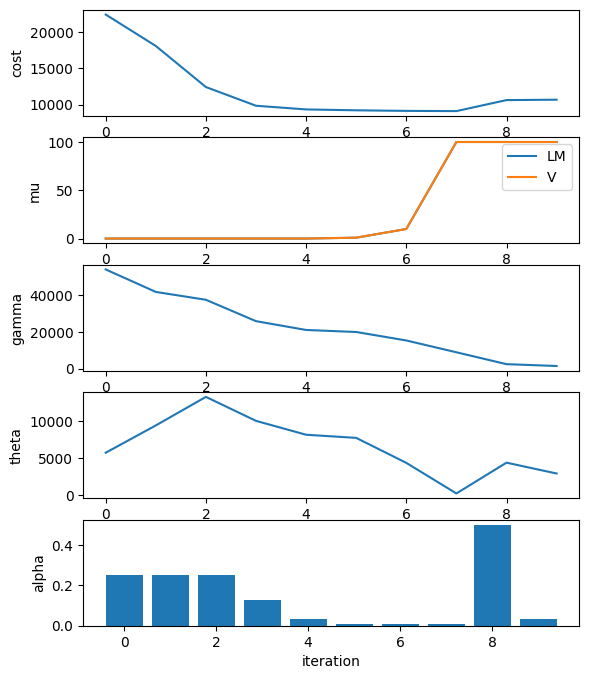

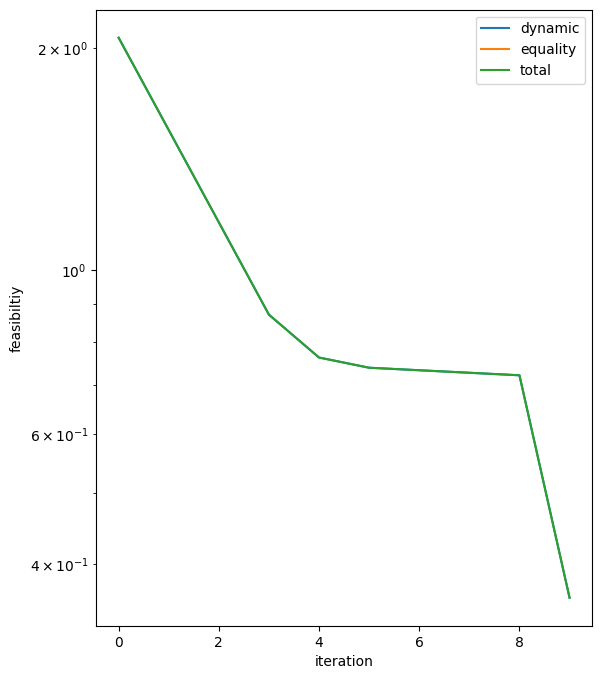

In [8]:
import importlib
import utils.costs
importlib.reload(utils.costs)
from utils.costs import handstand, upright, crouch, walking, jumping, add_lf_cost
import utils.models
importlib.reload(utils.models)
from utils.models import IAM_shoot, IAM_ccdContactFwd, IAM_ccdFreeFwd

costs_r,costs_t = upright(rmodel, state, actuation)

DT, N = 2.5e-2, 10
rho = 1 # 脚离地
contact_ids = [lf_id, rf_id, lh_id, rh_id]
# [lfcalf_id, rfcalf_id, lhcalf_id, rhcalf_id]
contact_model = ContactModel(state,contact_ids)
# 减少滑动
add_lf_cost(costs_r,state,actuation,contact_ids)
actionmodels = IAM_shoot(N,state, actuation, (costs_r,costs_t), contact_model, DT, rho)

# actionmodels = IAM_ccdContactFwd(N, state, actuation, (costs_r,costs_t), contacts, DT)
# actionmodels = IAM_ccdFreeFwd(N, state, actuation, (costs_r,costs_t), DT)

maxiter = 10
is_feasible = False
init_reg = 0.1

problem = crocoddyl.ShootingProblem(x0, actionmodels[:-1], actionmodels[-1])
solver = crocoddyl.SolverFDDP(problem)
log = crocoddyl.CallbackLogger()
solver.setCallbacks([log,crocoddyl.CallbackVerbose(),crocoddyl.CallbackDisplay(display)])

# 调cost权重，提前测试空中不会乱动
x00 = x0.copy()
# x00[2] += 0.1
xs = [x00] * (solver.problem.T + 1) # list of array即可
us = [np.zeros(12)] * solver.problem.T

# x0 = rmodel.defaultState
# xs = [x0] * (solver.problem.T + 1)
# ustatic = solver.problem.quasiStatic([x0] * solver.problem.T) # 初始化很重要,但要很长时间算
# us = [ustatic[0]]*solver.problem.T

print('Initialization success !')
solver.solve(xs, us, maxiter, is_feasible, init_reg)

print('Initial cost: ', solver.cost)
crocoddyl.plotOCSolution(log.xs, log.us)
crocoddyl.plotConvergence(
    log.costs, log.pregs, log.dregs, log.grads, log.stops, log.steps
)
crocoddyl.plotFeasibility(log.ffeass,log.hfeass)

In [18]:
from utils.costs import handstand, upright, crouch, add_lf_cost
costs_r,costs_t = upright(rmodel, state, actuation)

DT, N = 2.5e-2, 20
rho = 1 # 显著影响cost..., cost不收敛就要加大cost权重
# actionmodels = IAM_ccd(N,state, actuation, costs, contacts, DT)
contact_ids = [lf_id, rf_id, lh_id, rh_id,
               ]# , lfcalf_id, rfcalf_id, lhcalf_id, rhcalf_id]
contact_model = ContactModel(state,contact_ids)
add_lf_cost(costs_r,state,actuation,contact_ids) # 感觉没啥影响...
# actionmodels = IAM_contact(N,state, actuation, costs_t, contact_model, DT, rho)
actionmodels = IAM_shoot(N,state, actuation, [costs_r,costs_t], contact_model, DT, rho)

x_traj, u_traj = cimpc(0.5, x0, actionmodels)

Initialization success !
Initial cost: 12213.248036936528


  5%|▌         | 1/20 [00:00<00:11,  1.60it/s]

Step 1, cost: 16694.95066014581


 10%|█         | 2/20 [00:01<00:16,  1.08it/s]

Step 2, cost: 24403.61440003095


 15%|█▌        | 3/20 [00:03<00:21,  1.28s/it]

Step 3, cost: 23958.033607394562


 20%|██        | 4/20 [00:04<00:18,  1.15s/it]

Step 4, cost: 23958.877380996593


 25%|██▌       | 5/20 [00:06<00:20,  1.37s/it]

Step 5, cost: 23960.052904425163


 30%|███       | 6/20 [00:07<00:19,  1.41s/it]

Step 6, cost: 23961.501849572738


 35%|███▌      | 7/20 [00:09<00:18,  1.41s/it]

Step 7, cost: 23963.165128027456


 40%|████      | 8/20 [00:10<00:16,  1.39s/it]

Step 8, cost: 23964.92752582409


 45%|████▌     | 9/20 [00:11<00:14,  1.28s/it]

Step 9, cost: 23354.43768049387


 50%|█████     | 10/20 [00:12<00:13,  1.34s/it]

Step 10, cost: 23237.56017511513


 55%|█████▌    | 11/20 [00:14<00:11,  1.32s/it]

Step 11, cost: 23238.91686135683


 60%|██████    | 12/20 [00:15<00:10,  1.30s/it]

Step 12, cost: 23240.212097233303


 65%|██████▌   | 13/20 [00:16<00:08,  1.26s/it]

Step 13, cost: 23241.664110567395


 70%|███████   | 14/20 [00:17<00:07,  1.22s/it]

Step 14, cost: 23243.416207838254


 75%|███████▌  | 15/20 [00:18<00:05,  1.07s/it]

Step 15, cost: 19583.583059759425


 80%|████████  | 16/20 [00:19<00:04,  1.06s/it]

Step 16, cost: 19000.022509343853


 85%|████████▌ | 17/20 [00:20<00:03,  1.07s/it]

Step 17, cost: 18790.220553359024


 90%|█████████ | 18/20 [00:21<00:02,  1.13s/it]

Step 18, cost: 18788.009567878576


 95%|█████████▌| 19/20 [00:22<00:01,  1.11s/it]

Step 19, cost: 18786.038765968937


100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

Step 20, cost: 18781.009817694387


In [19]:
dts = [DT*10] * len(x_traj)
display.display(x_traj, dts, [], [], [], [], [], dts, 1)

AttributeError: 'function' object has no attribute 'display'

In [20]:
costs_r,costs_t = handstand(rmodel, state, actuation)

DT, N = 2.5e-2, 20
rho = 0.1 # 大一点cost突然下降
# actionmodels = IAM_ccd(N,state, actuation, costs, contacts, DT)
contact_ids = [lf_id, rf_id, lh_id, rh_id,
               ]# , lfcalf_id, rfcalf_id, lhcalf_id, rhcalf_id]
contact_model = ContactModel(state,contact_ids)
# 的确减少滑动了, 不滑动算的更快
add_lf_cost(costs_r,state,actuation,contact_ids)

# actionmodels = IAM_contact(N,state, actuation, costs, contact_model, DT, 0.1)
action_component = [N,state, actuation, [costs_r,costs_t], contact_model, DT, rho]

x_traj, u_traj = cimpc_adaptive(1, x0, action_component)

Initialization success !
Initial cost: 4194.864152262267


  2%|▎         | 1/40 [00:00<00:21,  1.82it/s]

Step 1, cost: 4181.236828857368


  5%|▌         | 2/40 [00:01<00:19,  1.96it/s]

Step 2, cost: 4180.546830132109


  8%|▊         | 3/40 [00:01<00:18,  2.01it/s]

Step 3, cost: 4179.9094427035825


 10%|█         | 4/40 [00:01<00:17,  2.04it/s]

Step 4, cost: 4179.319147170705


 12%|█▎        | 5/40 [00:02<00:17,  1.99it/s]

Step 5, cost: 4178.766727848705


 15%|█▌        | 6/40 [00:03<00:17,  1.99it/s]

Step 6, cost: 4178.244091155673


 18%|█▊        | 7/40 [00:03<00:16,  2.03it/s]

Step 7, cost: 4177.745574336969


 20%|██        | 8/40 [00:03<00:15,  2.03it/s]

Step 8, cost: 4177.2679338736725


 22%|██▎       | 9/40 [00:04<00:15,  2.05it/s]

Step 9, cost: 4176.809977219129


 25%|██▌       | 10/40 [00:04<00:13,  2.18it/s]

Step 10, cost: 172317.6914365882


 28%|██▊       | 11/40 [00:05<00:14,  1.94it/s]

Step 11, cost: 211832.5289926574


 30%|███       | 12/40 [00:06<00:15,  1.80it/s]

Step 12, cost: 185882.67203529688


 32%|███▎      | 13/40 [00:06<00:15,  1.73it/s]

Step 13, cost: 172906.785630414


 35%|███▌      | 14/40 [00:07<00:16,  1.55it/s]

Step 14, cost: 172990.44145542785


 38%|███▊      | 15/40 [00:08<00:17,  1.43it/s]

Step 15, cost: 173074.07850828563


 40%|████      | 16/40 [00:09<00:18,  1.27it/s]

Step 16, cost: 173157.63509782084


 42%|████▎     | 17/40 [00:10<00:19,  1.19it/s]

Step 17, cost: 23996064.201069016


 45%|████▌     | 18/40 [00:10<00:16,  1.37it/s]

Step 18, cost: 24011710.14366098


 48%|████▊     | 19/40 [00:11<00:13,  1.58it/s]

Step 19, cost: 24027355.829521712


 50%|█████     | 20/40 [00:11<00:11,  1.80it/s]

Step 20, cost: 24043000.610133734


 52%|█████▎    | 21/40 [00:11<00:09,  2.06it/s]

Step 21, cost: 24058638.596499454


 55%|█████▌    | 22/40 [00:12<00:07,  2.27it/s]

Step 22, cost: 24074272.431133132


 57%|█████▊    | 23/40 [00:12<00:06,  2.46it/s]

Step 23, cost: 24089910.03388421


 60%|██████    | 24/40 [00:12<00:06,  2.61it/s]

Step 24, cost: 24105546.968864173


 62%|██████▎   | 25/40 [00:13<00:05,  2.75it/s]

Step 25, cost: 24121181.29286806


 65%|██████▌   | 26/40 [00:13<00:04,  2.99it/s]

Step 26, cost: 24136812.47888505


 68%|██████▊   | 27/40 [00:13<00:04,  3.11it/s]

Step 27, cost: 24152439.707803357


 70%|███████   | 28/40 [00:14<00:03,  3.43it/s]

Step 28, cost: 24168061.78383578


 72%|███████▎  | 29/40 [00:14<00:03,  3.53it/s]

Step 29, cost: 24183674.74740577


 75%|███████▌  | 30/40 [00:14<00:02,  3.36it/s]

Step 30, cost: 24199274.626522675


 78%|███████▊  | 31/40 [00:14<00:02,  3.28it/s]

Step 31, cost: 24214829.598680083


 80%|████████  | 32/40 [00:15<00:02,  3.15it/s]

Step 32, cost: 24230346.83348308


 82%|████████▎ | 33/40 [00:15<00:02,  3.21it/s]

Step 33, cost: 24246102.816234916


 85%|████████▌ | 34/40 [00:15<00:01,  3.07it/s]

Step 34, cost: 24261675.717342004


 88%|████████▊ | 35/40 [00:16<00:01,  3.03it/s]

Step 35, cost: 24277243.423406


 90%|█████████ | 36/40 [00:16<00:01,  2.73it/s]

Step 36, cost: 24292777.35060821


 92%|█████████▎| 37/40 [00:17<00:01,  2.69it/s]

Step 37, cost: 24308041.90167147


 95%|█████████▌| 38/40 [00:17<00:00,  2.69it/s]

Step 38, cost: 24308041.90167147


 98%|█████████▊| 39/40 [00:17<00:00,  2.68it/s]

Step 39, cost: 24308041.90167147


100%|██████████| 40/40 [00:18<00:00,  2.19it/s]

Step 40, cost: 24308041.90167147


In [21]:
dts = [DT*10] * len(x_traj)
display.display(x_traj, dts, [], [], [], [], [], dts, 1)

AttributeError: 'function' object has no attribute 'display'